<a href="https://colab.research.google.com/github/KrolDaniel-DTEU/ML-FIT-3-16/blob/main/%D0%9B%D0%A012_%D0%9C%D0%9D_%D0%9A%D1%80%D0%BE%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moazeldsokyx_dogs_vs_cats_path = kagglehub.dataset_download('moazeldsokyx/dogs-vs-cats')

print('Data source import complete.')


Data source import complete.


In [2]:
moazeldsokyx_dogs_vs_cats_path

'/kaggle/input/dogs-vs-cats'

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = all messages, 3 = only errors
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [10]:
train_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/train'
val_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/validation'
test_dir =moazeldsokyx_dogs_vs_cats_path+'/dataset/test'

In [26]:
class_names = ['Cat', 'Dog']

# Генератор для тренування з аугментацією + нормалізацією для VGG16
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Генератор для валідації і тесту — тільки нормалізація
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генератор для тренувального набору
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Рекомендований розмір для VGG16
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Генератор для валідаційного набору
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Генератор для тестового набору
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


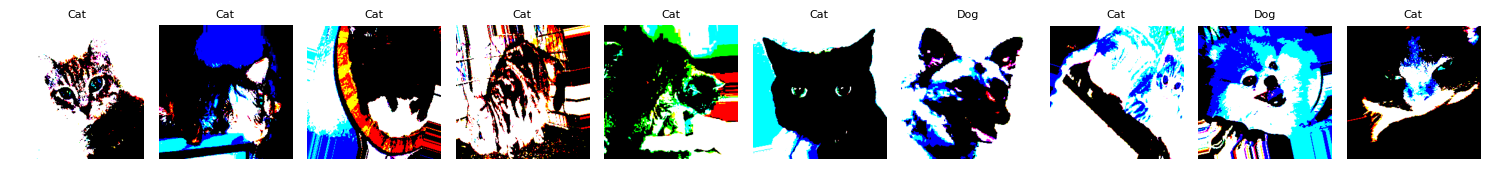

In [12]:
# Отримуємо новий набір зображень
images, labels = next(train_generator)

# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)

# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,           # Ми додаємо свої класифікатори
    input_shape=(224, 224, 3)
)

# Заморожуємо всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 306s 489ms/step - accuracy: 0.9665 - loss: 0.1297 - val_accuracy: 0.9822 - val_loss: 0.0735
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 510ms/step - accuracy: 0.9779 - loss: 0.0684 - val_accuracy: 0.9848 - val_loss: 0.0627
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 305s 488ms/step - accuracy: 0.9806 - loss: 0.0528 - val_accuracy: 0.9868 - val_loss: 0.0602
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 485ms/step - accuracy: 0.9814 - loss: 0.0522 - val_accuracy: 0.9850 - val_loss: 0.0586
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 489ms/step - accuracy: 0.9843 - loss: 0.0459 - val_accuracy: 0.9840 - val_loss: 0.0583


In [21]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
model.save("/content/drive/MyDrive/vgg16_cats_dogs.keras")

Mounted at /content/drive


In [22]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {acc:.2%}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 116s 297ms/step - accuracy: 0.9814 - loss: 0.0622
Test accuracy: 98.57%


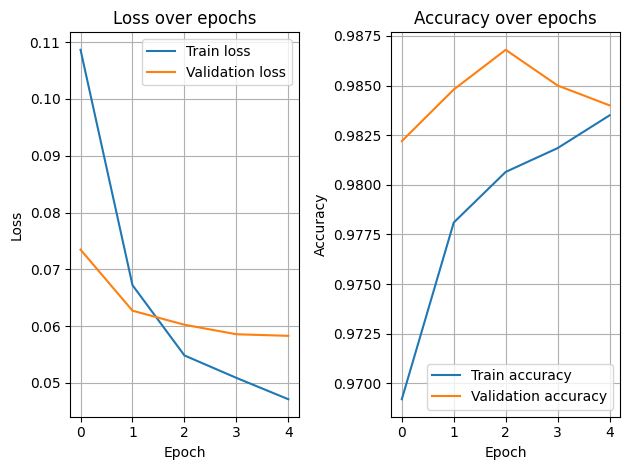

In [23]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


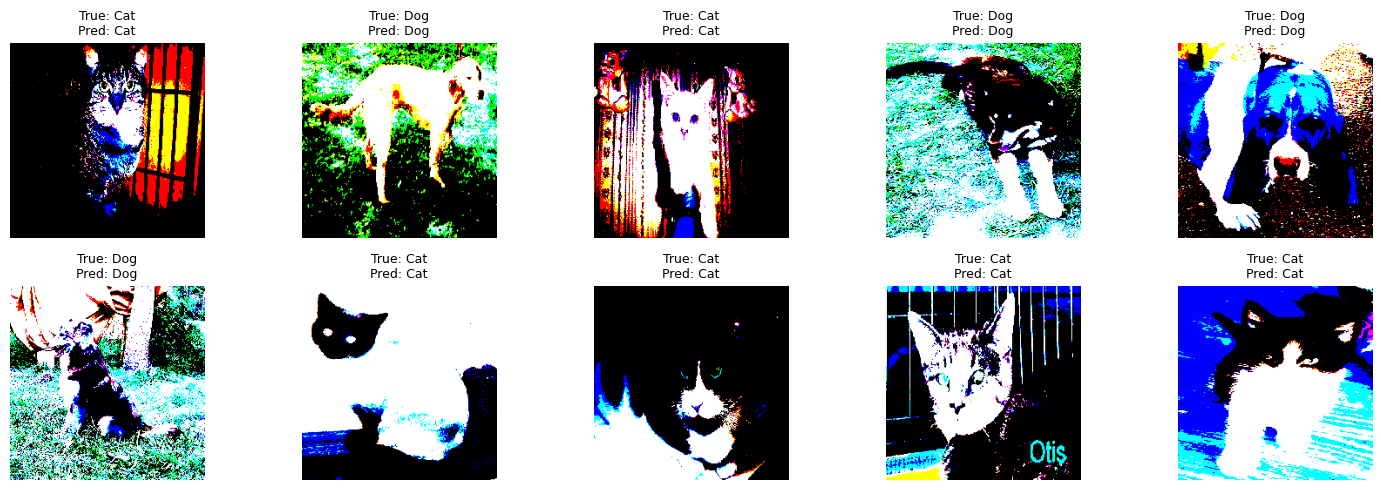

In [27]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

Варіант 2

Тюнінг


In [30]:
# Завантаження базової VGG16 без класифікатора
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# ❄️ Заморожуємо тільки нижні шари, а верхні розморозимо для fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# 🔁 Замість Flatten краще використовувати GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Створення фінальної моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 524ms/step - accuracy: 0.9677 - loss: 0.0908 - val_accuracy: 0.9788 - val_loss: 0.0576
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 515ms/step - accuracy: 0.9798 - loss: 0.0540 - val_accuracy: 0.9864 - val_loss: 0.0615
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 380s 512ms/step - accuracy: 0.9854 - loss: 0.0394 - val_accuracy: 0.9862 - val_loss: 0.0449
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 513ms/step - accuracy: 0.9867 - loss: 0.0360 - val_accuracy: 0.9872 - val_loss: 0.0466
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 520ms/step - accuracy: 0.9887 - loss: 0.0327 - val_accuracy: 0.9870 - val_loss: 0.0600


In [35]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
model.save("/content/drive/MyDrive/vgg16_cats_dogs_finetuned.keras")

Mounted at /content/drive


In [36]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {acc:.2%}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 69s 175ms/step - accuracy: 0.9877 - loss: 0.0420
Test accuracy: 98.76%


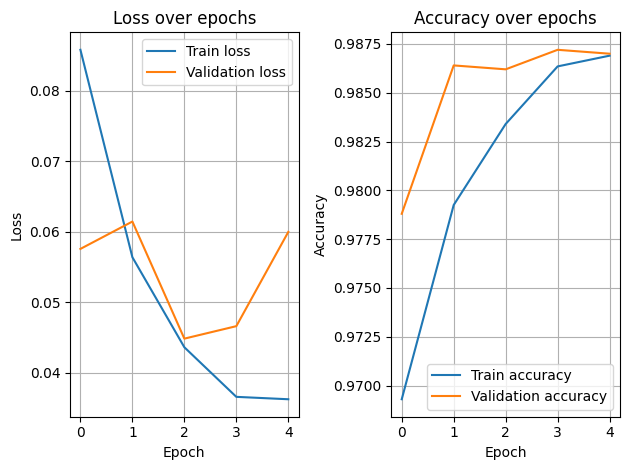

In [37]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


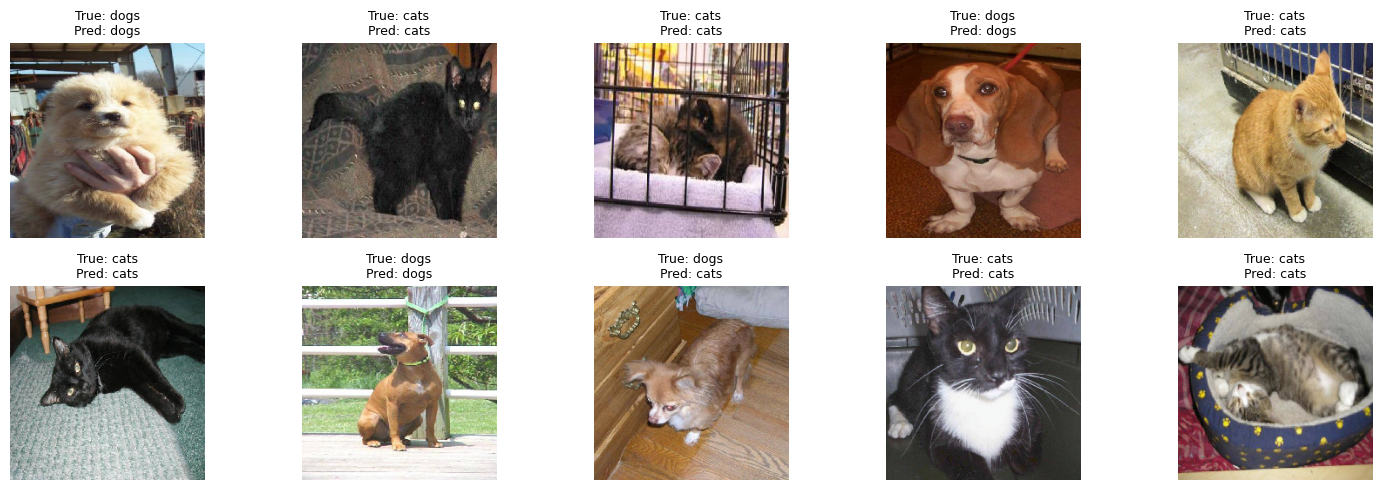

In [38]:
# Повертаємо генератор у початок (на всяк випадок)
test_generator.reset()


# Отримуємо один batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Отримуємо відповідність індексів класів
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}
class_names = [inv_class_indices[0], inv_class_indices[1]]  # ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Зображення після VGG16-preprocessing будуть зі зміненими значеннями
    # Повертаємо до нормального вигляду, якщо потрібно
    img = images[i].copy()
    img = img + [103.939, 116.779, 123.68]  # додаємо mean (VGG16)
    img = img[..., ::-1]  # з BGR → RGB
    img = np.clip(img / 255.0, 0, 1)  # для відображення

    plt.imshow(img)
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

Висновки

Використано претреновану модель для класифікації зображень VGG16. Донавчено на датасеті зображень котів та собак. Проведено аналіз точності моделі. Знайдено, що тестова точність дорівнює 98.57%. Виведено графіки навчання та порвняння справжнього значення та передбачуваного. Виконано тюнінг моделі. Вона отримала 98.76% тестової точності. Виведено графіки навчання та порвняння справжнього значення та передбачуваного finetuning моделі.